In [1]:
!nvidia-smi  # Check GPU connection and status (e.g., memory usage, driver version, etc.)

Fri May 16 08:39:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Step 1: Upload kaggle.json
from google.colab import files
files.upload()  # Upload the kaggle.json file here

# Step 2: Move it to the correct location
import os
import shutil

os.makedirs("/root/.config/kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.config/kaggle/kaggle.json")

# Step 3: Authenticate
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

print("✅ Kaggle API authenticated successfully!")


Saving kaggle.json to kaggle.json
✅ Kaggle API authenticated successfully!


In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate
api = KaggleApi()
api.authenticate()

# Download and unzip the dataset
dataset = "sureshbeekhani/brain-tumor"
download_path = "./brain-tumor"
os.makedirs(download_path, exist_ok=True)

api.dataset_download_files(dataset, path=download_path, unzip=True)

print("Dataset downloaded and extracted to:", download_path)


Dataset URL: https://www.kaggle.com/datasets/sureshbeekhani/brain-tumor
Dataset downloaded and extracted to: ./brain-tumor


In [4]:
IMAGE_SIZE = [224, 224] ## image size

In [5]:
size = [224, 224, 3]  # Resize images to 224x224 with 3 color channels (RGB)
size

[224, 224, 3]

In [6]:
train_path = '/content/brain-tumor/Brain Tumor/Training'  # Path to training dataset
valid_path = '/content/brain-tumor/Brain Tumor/Testing'   # Path to validation dataset

In [7]:
# Import TensorFlow library
import tensorflow as tf

# Import the pre-trained VGG16 model for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16

# Utilities for loading and preprocessing individual images
from tensorflow.keras.preprocessing import image

# Tools for generating batches of image data with real-time data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Import NumPy for numerical operations
import numpy as np

# Import glob to help retrieve file paths using patterns (e.g., *.jpg)
from glob import glob

# Import Keras model-building utilities
from tensorflow.keras.models import Sequential  # For building models layer-by-layer
from tensorflow.keras.models import Model       # For functional API models

# Import layers used for building the model architecture
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

# (Redundant) Re-import of ImageDataGenerator — can be removed to clean up code
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# Load the VGG16 model pre-trained on ImageNet, Without the fully connected (top) layers
# Set input shape to IMAGE_SIZE with 3 color channels (RGB)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
for layer in vgg16.layers:
    layer.trainable = False  # Freeze all VGG16 layers to prevent them from being updated during training

In [10]:
for layer in vgg16.layers:
    print(layer.name, layer.trainable)  # Print each layer's name and whether it's trainable

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [11]:
vgg16.summary()  # Display the architecture and details of the VGG16 model

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
from glob import glob

folders = glob(r'/content/brain-tumor/Brain Tumor/Training/*')# Get list of all class folders in the training directory
folders  # Display the list of class folder paths (e.g., categories of bone images)

['/content/brain-tumor/Brain Tumor/Training/glioma',
 '/content/brain-tumor/Brain Tumor/Training/meningioma',
 '/content/brain-tumor/Brain Tumor/Training/notumor',
 '/content/brain-tumor/Brain Tumor/Training/pituitary']

In [13]:
num_of_class = len(folders)  # Count the number of classes by counting folders in the training directory
num_of_class  # Display the number of classes

4

In [14]:
model = Sequential()  # Initialize a sequential model

model.add(vgg16)  # Add the pre-trained VGG16 convolutional base (without top layers)

model.add(Flatten())  # Flatten the output from VGG16 to a 1D vector

model.add(Dense(256, activation='relu'))  # Add a fully connected layer with 256 neurons and ReLU activation

model.add(Dense(num_of_class, activation='softmax'))  # Add output layer with neurons equal to number of classes, using softmax for multi-class classification

In [15]:
# view the structure of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
from tensorflow.keras.optimizers import Adam

# Set custom learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(
    loss='categorical_crossentropy',  # Good for multi-class classification
    optimizer=optimizer,              # Use the custom Adam with specified learning rate
    metrics=['accuracy']              # Track accuracy
)


In [17]:
# Data augmentation for training data to improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values from [0, 255] to [0, 1]
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in/out on images
    horizontal_flip=True    # Randomly flip images horizontally
)

# Only rescaling for test/validation data, no augmentation applied
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

In [18]:
training_set = train_datagen.flow_from_directory(
    train_path,                # Directory path to the training images organized by class folders
    target_size=(224, 224),   # Resize all images to 224x224 pixels
    batch_size=16,            # Number of images to be yielded per batch
    class_mode='categorical'  # Use categorical labels for multi-class classification
)

Found 5400 images belonging to 4 classes.


In [19]:
test_set = test_datagen.flow_from_directory(
    valid_path,                # Directory path to the validation/test images organized by class folders
    target_size=(224, 224),   # Resize all images to 224x224 pixels
    batch_size=16,            # Number of images to be yielded per batch
    class_mode='categorical'  # Use categorical labels for multi-class classification
)

Found 1200 images belonging to 4 classes.


In [20]:
r = model.fit(
    training_set,                 # Training data generator
    validation_data=test_set,     # Validation data generator to evaluate model performance after each epoch
    epochs=15,                   # Number of times to iterate over the entire training dataset
    steps_per_epoch=len(training_set),   # Number of batches to process in one epoch (typically total training samples / batch size)
    validation_steps=len(test_set)        # Number of validation batches to process (total validation samples / batch size)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 98s 263ms/step - accuracy: 0.7173 - loss: 0.6879 - val_accuracy: 0.8408 - val_loss: 0.4620
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 127s 243ms/step - accuracy: 0.8859 - loss: 0.3087 - val_accuracy: 0.8900 - val_loss: 0.3117
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 142s 243ms/step - accuracy: 0.9122 - loss: 0.2404 - val_accuracy: 0.9100 - val_loss: 0.2377
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 144s 250ms/step - accuracy: 0.9197 - loss: 0.2203 - val_accuracy: 0.9158 - val_loss: 0.2253
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.9300 - loss: 0.1762 - val_accuracy: 0.8975 - val_loss: 0.2940
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 145s 251ms/step - accuracy: 0.9478 - loss: 0.1480 - val_accuracy: 0.9375 - val_loss: 0.1718
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 142s 253ms/step - accuracy: 0.9523 - loss: 0.1348 - val_accuracy: 0.9450 - val_loss: 0.1382
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 139s 244ms/step - accuracy: 0.9502 - l

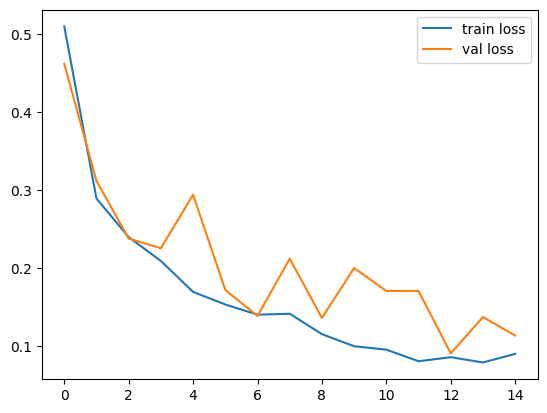

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting graphs

# Plot the training loss values stored in r.history['loss']
plt.plot(r.history['loss'], label='train loss')

# Plot the validation loss values stored in r.history['val_loss']
plt.plot(r.history['val_loss'], label='val loss')

# Add a legend to the plot to distinguish between training and validation loss lines
plt.legend()

# Display the plot on the screen
plt.show()

# Save the current figure as an image file named 'LossVal_loss.png' (PNG extension is recommended)
plt.savefig('LossVal_loss.png')

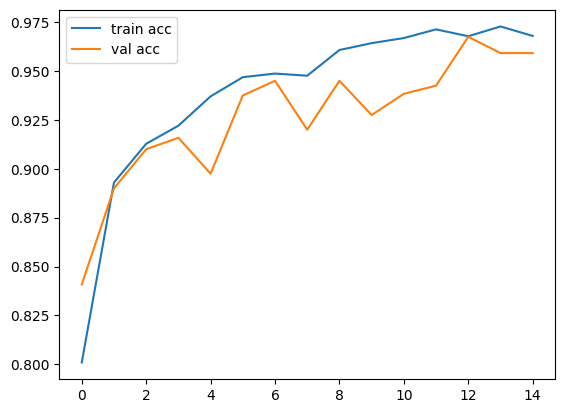

In [22]:
# Plot training accuracy values stored in r.history['accuracy']
plt.plot(r.history['accuracy'], label='train acc')

# Plot validation accuracy values stored in r.history['val_accuracy']
plt.plot(r.history['val_accuracy'], label='val acc')

# Add legend to distinguish the two lines
plt.legend()

# Save the plot as an image file before displaying it
plt.savefig('AccVal_acc.png')

# Display the plot on the screen
plt.show()


In [23]:
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9649 - loss: 0.1114
Test Loss: 0.1132
Test Accuracy: 0.9592


In [71]:
from tensorflow.keras.models import load_model  # Import load_model to load saved Keras models later

model.save('model_vgg16.keras')  # Save the trained model to a file named 'model_vgg16.h5' in HDF5 format

In [72]:
from tensorflow.keras.preprocessing import image

In [73]:
img = "/content/brain-tumor/Brain Tumor/Testing/notumor/Te-noTr_0008.jpg"

In [74]:
img=image.load_img(img,target_size=(224,224))

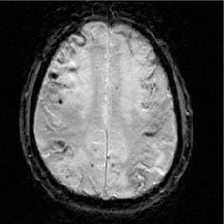

In [75]:
img

In [76]:
x=image.img_to_array(img)
x

array([[[ 54.,  54.,  54.],
        [ 61.,  61.,  61.],
        [ 61.,  61.,  61.],
        ...,
        [ 57.,  57.,  57.],
        [ 53.,  53.,  53.],
        [113., 113., 113.]],

       [[  0.,   0.,   0.],
        [  3.,   3.,   3.],
        [  0.,   0.,   0.],
        ...,
        [  3.,   3.,   3.],
        [  0.,   0.,   0.],
        [ 59.,  59.,  59.]],

       [[  7.,   7.,   7.],
        [  9.,   9.,   9.],
        [  4.,   4.,   4.],
        ...,
        [ 10.,  10.,  10.],
        [  6.,   6.,   6.],
        [ 66.,  66.,  66.]],

       ...,

       [[  2.,   2.,   2.],
        [  4.,   4.,   4.],
        [  2.,   2.,   2.],
        ...,
        [  7.,   7.,   7.],
        [  3.,   3.,   3.],
        [ 63.,  63.,  63.]],

       [[  1.,   1.,   1.],
        [  4.,   4.,   4.],
        [  1.,   1.,   1.],
        ...,
        [  7.,   7.,   7.],
        [  2.,   2.,   2.],
        [ 62.,  62.,  62.]],

       [[  0.,   0.,   0.],
        [  3.,   3.,   3.],
        [  1.,  

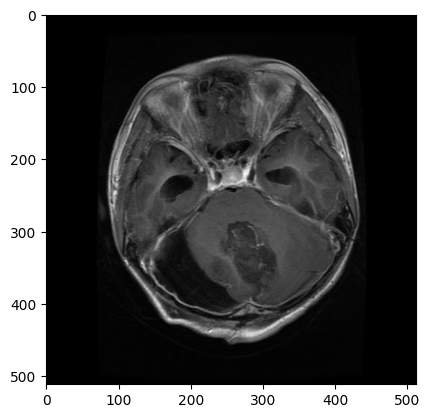

In [77]:
Z = plt.imread('/content/brain-tumor/Brain Tumor/Testing/glioma/Te-glTr_0000.jpg')
plt.imshow(Z)

In [78]:
x.shape

(224, 224, 3)

In [79]:
x=x/255

In [80]:
from keras.applications.vgg16 import preprocess_input
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)

In [81]:
output = model.predict(img_data)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[2.1441083e-06, 2.9242807e-04, 9.9970537e-01, 1.0336050e-09]],
      dtype=float32)

In [82]:
result = np.argmax(output, axis=1)
result

array([2])

In [83]:
import numpy as np

# Get the predicted class index (e.g., 0 = glioma, 1 = meningioma, etc.)
result = np.argmax(output, axis=1)

# Define the class labels in the correct order
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Get the class name
prediction = labels[result[0]]

# Display the prediction
print(f"Predicted class: {prediction}")


Predicted class: notumor
